<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

# **Artificial Intelligence - MSc**
## ET5003 - MACHINE LEARNING APPLICATIONS 

### Instructor: Enrique Naredo
### ET5003_KaggleCompetition

#@title Current Date
Today = '2021-10-15' #@param {type:"date"}


#@markdown ---  
#@markdown ### Enter your details here:  
Team_Number = "1" #@param {type:"string"}  
Student_ID&Name = "20156952 Dáire Campbell" #@param {type:"string"}  
Student_ID&Name = "20151586 Carlos Amaral" #@param {type:"string"}  
Student_ID&Name = "9022724 Nigel Portley" #@param {type:"string"}  
Student_ID&Name = "20172257 Stephen Quirke" #@param {type:"string"}  
Student_ID&Name = "20214537 Tom Keane" #@param {type:"string"}  
#@markdown ---  

In [1]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = "Final" #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

# INTRODUCTION

Your introduction here.

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [2]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [5]:
# Scikit-learn is an open source machine learning library 
# that supports supervised and unsupervised learning
# https://scikit-learn.org/stable/
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [6]:
# Regular expression operations
#https://docs.python.org/3/library/re.html
import re 

# Natural Language Toolkit
# https://www.nltk.org/install.html
import nltk

# Stemming maps different forms of the same word to a common “stem” 
# https://pypi.org/project/snowballstemmer/
from nltk.stem import SnowballStemmer

# https://www.nltk.org/book/ch02.html
from nltk.corpus import stopwords

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer



In [7]:
# Modules for visuals
# use seaborn plotting defaults
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = [12, 8] 

# XGBoost for feature selection
from xgboost import XGBClassifier
from xgboost import plot_importance

# Improve the Jupyter Notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Improve pandas dataframe results
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [8]:
# NLP library
import spacy

# Pretty print
import pprint

In [9]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-CS6134/CS6134_SEM1_2021-2/tree/main/Week-5). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Get the dataset: train, test, and true price.

In [62]:
# The code runs quicker locally, but
# I have a Colab version for distribution.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Path, copy the path from your Drive
    Path = '/content/drive/MyDrive/Masters_in_AI/et5003/etivity2/'
    print("Running in Colab.")
except Exception as e:
    print("Running locally.")
    Path = "./"

Running locally.


In [63]:
# Load data
house_train_ = pd.read_csv(Path+"house_train.csv")
house_train_ = house_train_[house_train_["price"].notna()]
house_train_ = house_train_.rename(columns = {"price": "Expected"})

house_test_ = pd.read_csv(Path+"house_test.csv")
true_price = pd.read_csv(Path+"true_price.csv")
# Add house value to the dataset

house_test_ = house_test_.merge(
    true_price,
    left_on = "ad_id",
    right_on = "Id",
    how = "inner")

<AxesSubplot:xlabel='Expected', ylabel='Density'>

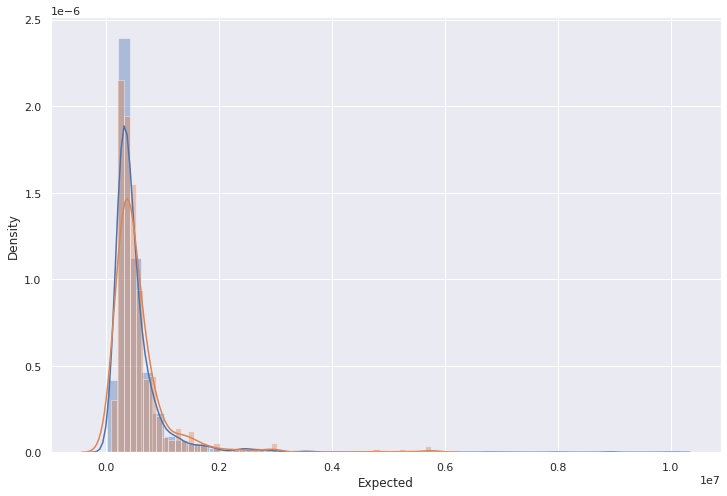

In [64]:
# Confirm the price distributions are the similiar
# between the reaining and test datasets.
sns.distplot(house_train_["Expected"])
sns.distplot(house_test_["Expected"])

## Clean the dataset: remove nan's and possible outliers.

In [65]:
# Map from area to Dublin postcode
# This will reduce number of features in areas
area_to_postcode = {
    'Temple Bar':'Dublin 1', 'IFSC':'Dublin 1', 
    'Grand Canal Dock':'Dublin 2',
    'Clontarf':'Dublin 3', 'East Wall':'Dublin 3', 'North Strand':'Dublin 3', 'Fairview':'Dublin 3', 'Marino':'Dublin 3', 'Ballyboughal':'Dublin 3', 
    'Ballsbridge':'Dublin 4', 'Donnybrook':'Dublin 4','Sandymount':'Dublin 4','Ringsend':'Dublin 4','Irishtown':'Dublin 4','Merrion':'Dublin 4',
    'Artane':'Dublin 5','Raheny':'Dublin 5','Kilbarrack':'Dublin 5','Edenmore':'Dublin 5','Kilmore':'Dublin 5','Donnycarney':'Dublin 5',
    'Rathmines':'Dublin 6','Rathgar':'Dublin 6','Ranelagh':'Dublin 6','Milltown':'Dublin 6','Dartry':'Dublin 6',
    'Stoneybatter':'Dublin 7','Phibsborough':'Dublin 7','Navan Road (D7)':'Dublin 7','North Circular Road':'Dublin 7','Smithfield':'Dublin 7','Ashtown':'Dublin 7','Cabra':'Dublin 7',
    'Kilmainham':'Dublin 8','Inchicore':'Dublin 8','Rialto':'Dublin 8','Portobello':'Dublin 8','South Circular Road':'Dublin 8','Islandbridge':'Dublin 8','The Coombe':'Dublin 8',"Dolphin's Barn":'Dublin 8','Christchurch':'Dublin 8',
    'Drumcondra':'Dublin 9','Glasnevin':'Dublin 9','Santry':'Dublin 9','Whitehall':'Dublin 9','Beaumont':'Dublin 9','Ballymun':'Dublin 9','Poppintree':'Dublin 9',
    'Ballyfermot':'Dublin 10','Cherry Orchard':'Dublin 10',
    'Finglas':'Dublin 11',"St Margaret's":'Dublin 11',
    'Walkinstown':'Dublin 12','Crumlin':'Dublin 12','Drimnagh':'Dublin 12','Bluebell':'Dublin 12','Park West':'Dublin 12','Perrystown':'Dublin 12',
    'Malahide':'Dublin 13','Howth':'Dublin 13','Sutton':'Dublin 13','Baldoyle':'Dublin 13','Donaghmede':'Dublin 13','Bayside':'Dublin 13','Ard Na Greine':'Dublin 13','Clongriffin':'Dublin 13','Clarehall':'Dublin 13',
    'Dundrum':'Dublin 14','Churchtown':'Dublin 14','Goatstown':'Dublin 14','Clonskeagh':'Dublin 14','Windy Arbour':'Dublin 14',
    'Carpenterstown':'Dublin 15','Castleknock':'Dublin 15','Clonsilla':'Dublin 15','Blanchardstown':'Dublin 15','Clonee':'Dublin 15','Coolmine':'Dublin 15','Hartstown':'Dublin 15','Mulhuddart':'Dublin 15','The Ward':'Dublin 15','Ongar':'Dublin 15','Tyrrelstown':'Dublin 15',
    'Rathfarnham':'Dublin 16','Ballinteer':'Dublin 16','Ballinascorney':'Dublin 16','Knocklyon':'Dublin 16',
    'Darndale':'Dublin 17','Clonshaugh':'Dublin 17','Coolock':'Dublin 17','Killester':'Dublin 17',
    'Deansgrange':'Dublin 18','Sandyford':'Dublin 18','Foxrock':'Dublin 18','Stepaside':'Dublin 18','Cabinteely':'Dublin 18','Carrickmines':'Dublin 18','Leopardstown':'Dublin 18','Kilternan':'Dublin 18','Shankill':'Dublin 18',
    'Palmerstown':'Dublin 20','Chapelizod':'Dublin 20','Lucan':'Dublin 20',
    'Clondalkin':'Dublin 22','Kingswood':'Dublin 22','Newcastle':'Dublin 22',
    'Ballymount':'Dublin 24','Kiltipper':'Dublin 24','Tallaght':'Dublin 24','Balrothery':'Dublin 24','Rathcoole':'Dublin 24','Kilnamanagh':'Dublin 24','Firhouse':'Dublin 24','Greenhills':'Dublin 24','Oldbawn':'Dublin 24','Adamstown':'Dublin 24','Saggart':'Dublin 24','Citywest':'Dublin 24','Ballycullen':'Dublin 24','Brittas':'Dublin 24',
    'Terenure':'Dublin 6w',"Harold's Cross":'Dublin 6w','Kimmage':'Dublin 6w','Templeogue':'Dublin 6w',
    'Donabate':'Co. Fingal','Swords':'Co. Fingal','Portmarnock':'Co. Fingal','Kinsealy':'Co. Fingal','Balgriffin':'Co. Fingal','Garristown':'Co. Fingal','Naul':'Co. Fingal','Skerries':'Co. Fingal','Rush':'Co. Fingal','Lusk':'Co. Fingal','Balbriggan':'Co. Fingal','Loughshinny':'Co. Fingal','Ballybough':'Co. Fingal',
    'Blackrock':'Co. Dun Laoghaire-Rathdown','Dun Laoghaire':'Co. Dun Laoghaire-Rathdown','Glenageary':'Co. Dun Laoghaire-Rathdown',
    'Monkstown':'Co. Dun Laoghaire-Rathdown','Booterstown':'Co. Dun Laoghaire-Rathdown','Sandycove':'Co. Dun Laoghaire-Rathdown',
    'Rathmichael':'Co. Dun Laoghaire-Rathdown','Mount Merrion':'Co. Dun Laoghaire-Rathdown','Ballybrack':'Co. Dun Laoghaire-Rathdown','Sallynoggin':'Co. Dun Laoghaire-Rathdown',
    'Kilmacud':'Co. Dun Laoghaire-Rathdown','Dalkey':'Co. Dun Laoghaire-Rathdown','Killiney':'Co. Dun Laoghaire-Rathdown','Loughlinstown':'Co. Dun Laoghaire-Rathdown',
    }

In [15]:
# Map from Dublin postcode to a flag 
# if its southside or northside
postcode_north_south = {
    "Co. Fingal":False,
    "Co. Dun Laoghaire-Rathdown":True,
    "Dublin 4":True,
    "Dublin 18":True,
    "Dublin 15":False,
    "Dublin 6":True,
    "Dublin 6w":True,
    "Dublin 3":False,
    "Dublin 16":True,
    "Dublin 13":False,
    "Dublin 9":False,
    "Dublin 7":False,
    "Dublin 24":True,
    "Dublin 20":True,
    "Dublin 5":False,
    "Dublin 12":True,
    "Dublin 8":True,
    "Dublin 14":True,
    "Dublin 22":True,
    "Dublin 17":False,
    "Dublin 11":False,
    "Dublin 2":True,
    "Dublin 10":True,
    "Dublin 1":False
}

In [16]:
def pre_processing_features(df_, train_data):
    """
    Function to preprocess features.
    This includes One-Hot Encoding and 
    encoding columns.

    Creating a function as will be applied to both 
    Training and Testing data.

    ::param df: (pandas dataframe)
    ::param data: (pandas dataframe)
        Data to use to fill empty values and to encode
        Using Training data to not bias results
    ::param ber_dict: (dict)
    ::return: (pandas dataframe)
    """
    df = df_.copy(deep = True)
    # Creating a mapping from ber letter to number
    # ber classification is ordinal
    ber_numbers = sorted(train_data.ber_classification.fillna(
        train_data.ber_classification.mode()[0]).unique())
    ber_dict = dict(zip(ber_numbers, range(len(ber_numbers))))
    
    # Encoding
    # Fill NaN values with mode
    df["ber_classification"] = df["ber_classification"]\
        .map(ber_dict)\
        .fillna(ber_dict[df.ber_classification.mode()[0]])
    
    return df


def create_new_features(dataframe_, train_data):
    """
    Functions to parse out new feaures from the dataframe.
    These are:
        - Alarm
        - Gas Fired Central Heating
        - Oil Fired Central Heating
        - Parking
        - Wheelchair Access
        - Wired for Cable Television

    ::param dataframe: (pandas DataFrame)
    ::return: (pandas DataFrame)
    """
    dataframe = dataframe_.copy(deep = True)
    print(
        "Percentage Facility populated: ",
        sum(dataframe["facility"].notna())*100/len(dataframe), "%")
    
    for fac in [
        "Alarm",
        "Gas Fired Central Heating",
        "Oil Fired Central Heating",
        "Parking",
        "Wheelchair Access",
        "Wired for Cable Television"]:
        dataframe[fac.lower().replace(" ", "_")] = dataframe["facility"].str.contains(fac).fillna(False)
    
    dataframe["postcode"] = dataframe["area"].map(area_to_postcode)
    
    postcode = pd.get_dummies(dataframe["postcode"])
    dataframe[postcode.columns] = postcode
    
    dataframe["postcode_north_south"] = dataframe["postcode"].map(postcode_north_south)

    # Via Nigel Portley
    # Convert the Property to Ordinal Type
    dataframe["property_type"] = dataframe["property_type"].map({
        "apartment": 1,
        "bungalow": 5,
        "detached": 9,
        "duplex": 2,
        "end-of-terrace": 6,
        "semi-detached": 8,
        "site": 3,
        "studio": 0,
        "terraced": 4,
        "townhouse": 7
    })

    dataframe = pre_processing_features(dataframe, train_data)
    
    return dataframe

In [17]:
# Apply preprocessing
house_train = create_new_features(house_train_, house_train_)
house_test = create_new_features(house_test_, house_train_)

Percentage Facility populated:  32.84923928077455 %
Percentage Facility populated:  37.8 %


In [18]:
# Add columns to test data from training data
# These could be missing from One Hot Encoding etc

for column in list(
    set(house_train.columns) - set(house_test.columns)):
    print(column)
    house_test[column] = 0

In [19]:
# Describe the Features
house_train.describe(include='all')

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,Expected,property_category,property_type,surface,alarm,gas_fired_central_heating,oil_fired_central_heating,parking,wheelchair_access,wired_for_cable_television,postcode,Co. Dun Laoghaire-Rathdown,Co. Fingal,Dublin 1,Dublin 10,Dublin 11,Dublin 12,Dublin 13,Dublin 14,Dublin 15,Dublin 16,Dublin 17,Dublin 18,Dublin 2,Dublin 20,Dublin 22,Dublin 24,Dublin 3,Dublin 4,Dublin 5,Dublin 6,Dublin 6w,Dublin 7,Dublin 8,Dublin 9,postcode_north_south
count,2.892000e+03,2892,2892.000000,2892.000000,2892.000000,2892,2892,2892,950,2892,2892.000000,2892.000000,7.000000,2.892000e+03,2892,2892.000000,2402.000000,2892,2892,2892,2892,2892,2892,2696,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2696
unique,NaN,152,NaN,NaN,NaN,1,2889,1,34,1856,NaN,NaN,NaN,NaN,2,NaN,NaN,2,2,2,2,2,2,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,Finglas,NaN,NaN,NaN,Dublin,O'Connor Estate Agents are honoured to present...,prod,"Parking,Gas Fired Central Heating",None,NaN,NaN,NaN,NaN,sale,NaN,NaN,False,False,False,False,False,False,Co. Fingal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
freq,NaN,92,NaN,NaN,NaN,2892,2,2892,184,1031,NaN,NaN,NaN,NaN,2885,NaN,NaN,2569,2275,2819,2053,2833,2490,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1422
mean,1.230511e+07,NaN,1.991355,2.975450,8.909059,NaN,NaN,NaN,NaN,NaN,53.355579,-6.257373,1.142857,5.323536e+05,NaN,5.073306,315.199039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087483,0.103734,0.003458,0.004495,0.031812,0.029737,0.060512,0.029046,0.073997,0.044260,0.010028,0.053596,0.003458,0.033195,0.024550,0.061895,0.033195,0.043914,0.023513,0.027663,0.026971,0.032158,0.021438,0.068119,NaN
std,2.173032e+05,NaN,1.266439,1.452494,2.793423,NaN,NaN,NaN,NaN,NaN,0.086445,0.142864,0.377964,5.678148e+05,NaN,3.037894,4414.586954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.282590,0.304968,0.058712,0.066907,0.175529,0.169891,0.238474,0.167964,0.261812,0.205708,0.099652,0.225258,0.058712,0.179176,0.154777,0.241006,0.179176,0.204940,0.151553,0.164032,0.162027,0.176449,0.144866,0.251993,NaN
min,9.124101e+06,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,51.458439,-6.521183,1.000000,1.999500e+04,NaN,0.000000,3.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,1.227543e+07,NaN,1.000000,2.000000,7.000000,NaN,NaN,NaN,NaN,NaN,53.299255,-6.313874,1.000000,2.800000e+05,NaN,1.000000,73.725000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,1.237885e+07,NaN,2.000000,3.000000,9.000000,NaN,NaN,NaN,NaN,NaN,53.345455,-6.252335,1.000000,3.800000e+05,NaN,5.000000,99.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,1.240400e+07,NaN,3.000000,4.000000,10.000000,NaN,NaN,NaN,NaN,NaN,53.388423,-6.197056,1.000000,5.750000e+05,NaN,8.000000,140.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

Columns : property_type
1    756
8    749
4    549
9    385
6    235
5     80
2     60
3     48
7     27
0      3
Name: property_type, dtype: int64

Columns : ber_classification
9.0     891
10.0    272
8.0     264
7.0     242
6.0     211
11.0    182
12.0    168
14.0    164
13.0    163
5.0     130
4.0      73
2.0      66
15.0     25
1.0      24
3.0      16
0.0       1
Name: ber_classification, dtype: int64

Columns : postcode
Co. Fingal                    300
Co. Dun Laoghaire-Rathdown    253
Dublin 15                     214
Dublin 9                      197
Dublin 24                     179
Dublin 13                     175
Dublin 18                     155
Dublin 16                     128
Dublin 4                      127
Dublin 20                      96
Dublin 3                       96
Dublin 7                       93
Dublin 11                      92
Dublin 12                      86
Dublin 14                      84
Dublin 6                       80
Dublin 6w                  

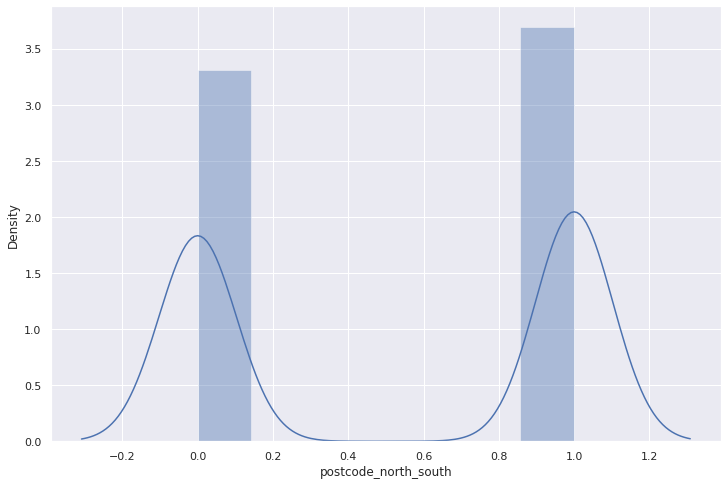


Columns : beds


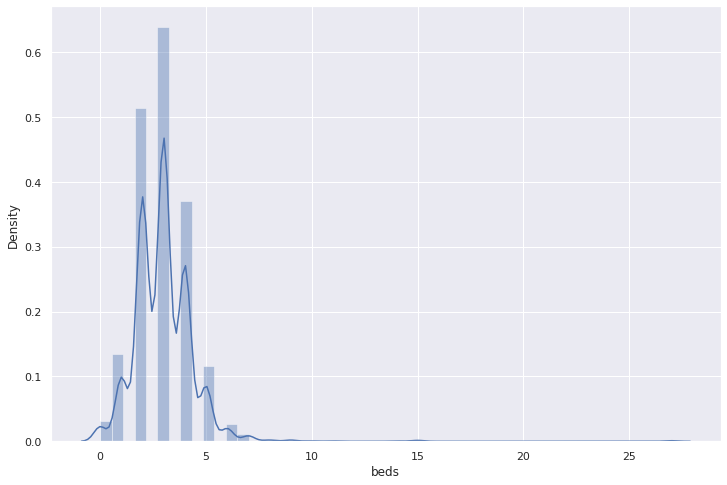


Columns : bathrooms


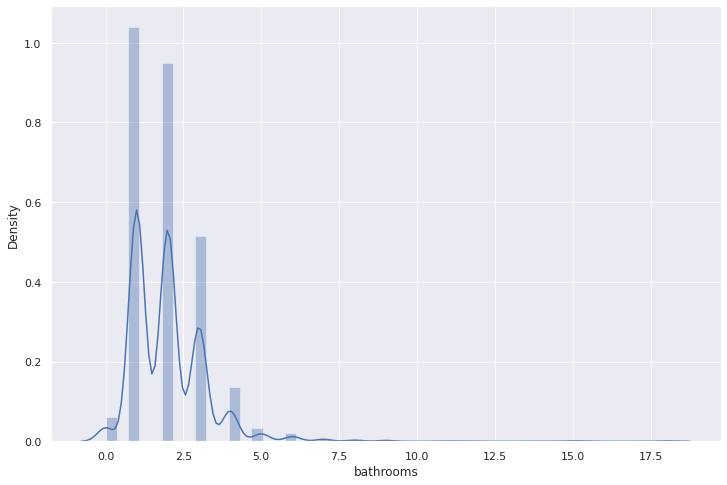


Columns : surface


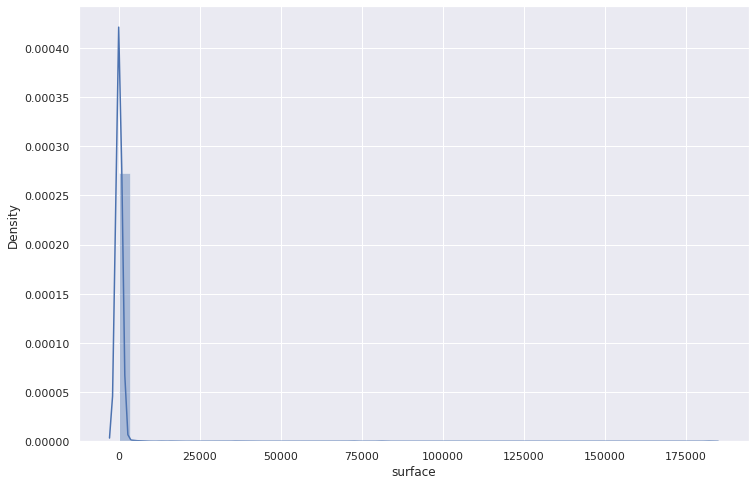


Columns : latitude


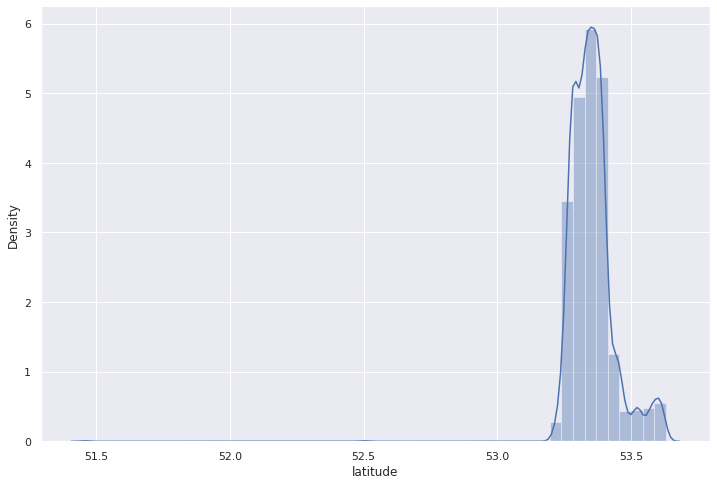


Columns : longitude


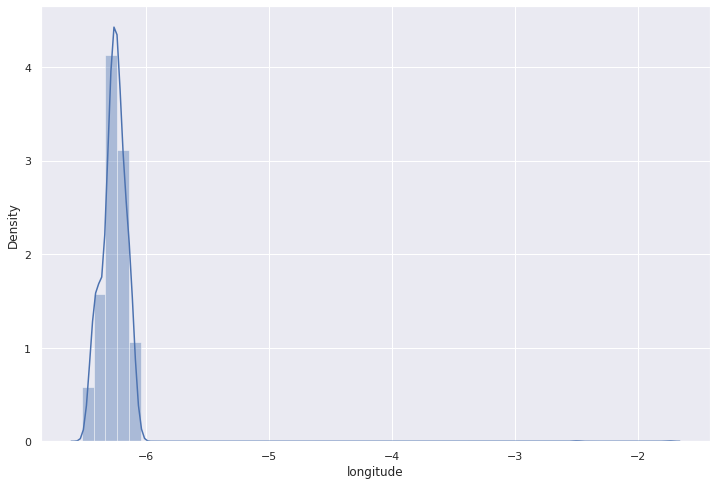


Columns : cost


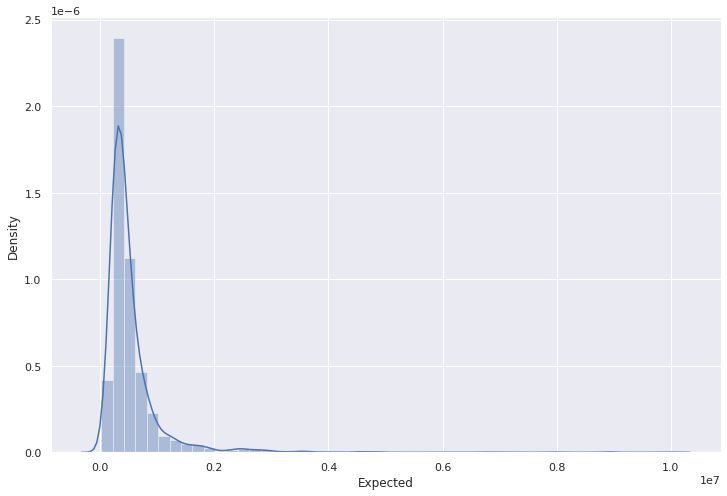

In [20]:
# Visualise distribution
for column in [
    "property_type","ber_classification","postcode"]:
    print("Columns :", column)
    pprint.pprint(house_train[column].value_counts())
    print("")
    
for column in [
    "postcode_north_south", "beds", "bathrooms", "surface", "latitude", "longitude"]:
    print("Columns :", column)
    sns.distplot(house_train[column])
    plt.show()
    print("")

print("Columns :", "cost")
sns.distplot(house_train["Expected"])
plt.show()

In [21]:
# Features to train model on
feature_cols = [
    'latitude',
    'longitude',
    'bathrooms',
    'beds',
    'surface', 'postcode_north_south',
    'ber_classification',
    "property_type",
    'alarm',
    'gas_fired_central_heating',
    'oil_fired_central_heating',
    'parking',
    'wheelchair_access',
    'wired_for_cable_television',
    'Co. Dun Laoghaire-Rathdown',
    'Co. Fingal',
    'Dublin 1',
    'Dublin 10',
    'Dublin 11',
    'Dublin 12',
    'Dublin 13',
    'Dublin 14',
    'Dublin 15',
    'Dublin 16',
    'Dublin 17',
    'Dublin 18',
    'Dublin 2',
    'Dublin 20',
    'Dublin 22',
    'Dublin 24',
    'Dublin 3',
    'Dublin 4',
    'Dublin 5',
    'Dublin 6',
    'Dublin 6w',
    'Dublin 7',
    'Dublin 8',
    'Dublin 9',
    #'postcode_north_south',
]

Below we remove the outliers from the data.

In [22]:
print(f"Origional length of training data: {len(house_train)}")
print(f"Origional length of test data: {len(house_test)}")

house_train = house_train[house_train["surface"] < 400]
print(f"Length of house_train is now {len(house_train)}, after removing surface outliers.")
house_test = house_test[house_test["surface"] < 400]
print(f"Length of house_test is now {len(house_test)}, after removing surface outliers.")

house_train = house_train[house_train["beds"] > 0]
print(f"Length of house_train is now {len(house_train)}, after removing beds outliers.")
house_test = house_test[house_test["beds"] > 0]
print(f"Length of house_test is now {len(house_test)}, after removing beds outliers.")

house_train = house_train[house_train["bathrooms"] >0]
print(f"Length of house_train is now {len(house_train)}, after removing bathroom outliers.")
house_test = house_test[house_test["bathrooms"] >0]
print(f"Length of house_test is now {len(house_test)}, after removing bathroom outliers.")

house_train = house_train[house_train["longitude"] < -6]
print(f"Length of house_train is now {len(house_train)}, after removing longitude outliers.")
house_test = house_test[house_test["longitude"] < -6]
print(f"Length of house_test is now {len(house_test)}, after removing longitude outliers.")

house_train = house_train[house_train["latitude"] > 53]
print(f"Length of house_train is now {len(house_train)}, after removing latitude outliers.")
house_test = house_test[house_test["latitude"] > 53]
print(f"Length of house_test is now {len(house_test)}, after removing latitude outliers.")

house_train = house_train.dropna(axis=0, subset = feature_cols)
print(f"Length of house_train is now {len(house_train)}, after removing Null values.")
house_test = house_test.dropna(axis=0, subset = feature_cols)
print(f"Length of house_test is now {len(house_test)}, after removing Null values.")


Origional length of training data: 2892
Origional length of test data: 500
Length of house_train is now 2327, after removing surface outliers.
Length of house_test is now 483, after removing surface outliers.
Length of house_train is now 2318, after removing beds outliers.
Length of house_test is now 480, after removing beds outliers.
Length of house_train is now 2305, after removing bathroom outliers.
Length of house_test is now 477, after removing bathroom outliers.
Length of house_train is now 2304, after removing longitude outliers.
Length of house_test is now 477, after removing longitude outliers.
Length of house_train is now 2304, after removing latitude outliers.
Length of house_test is now 477, after removing latitude outliers.
Length of house_train is now 2141, after removing Null values.
Length of house_test is now 453, after removing Null values.


Columns : postcode_north_south


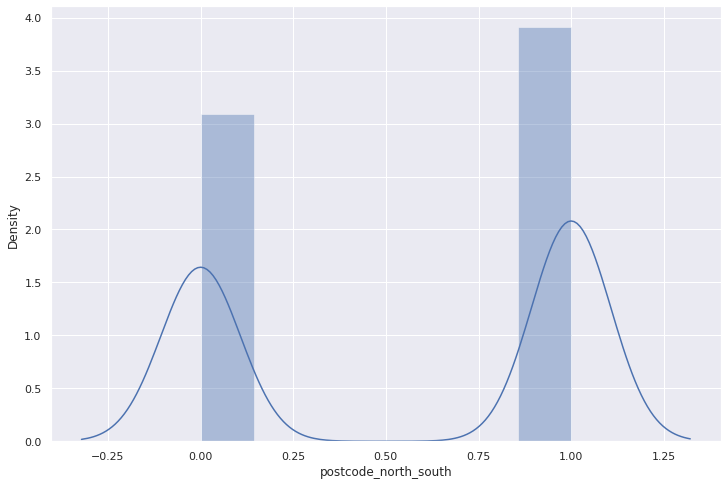


Columns : beds


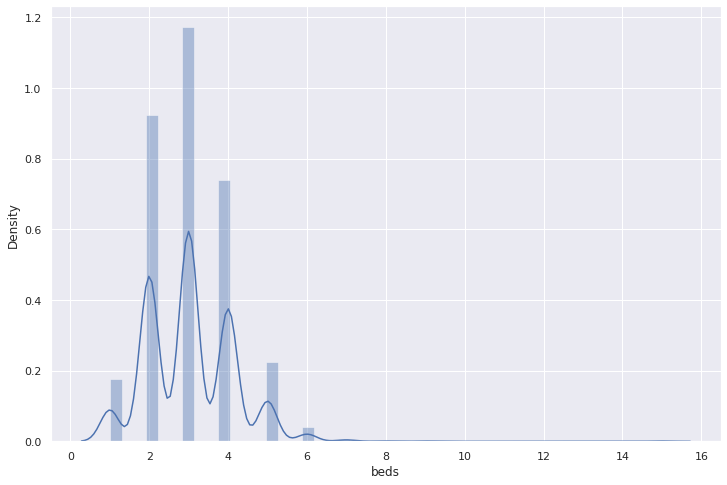


Columns : bathrooms


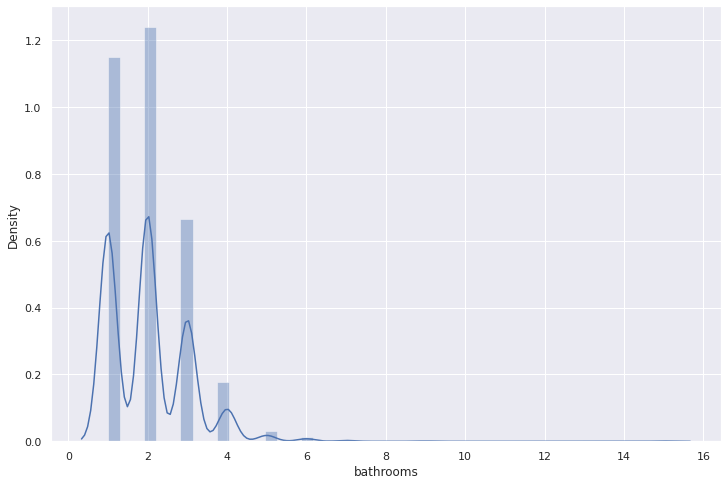


Columns : surface


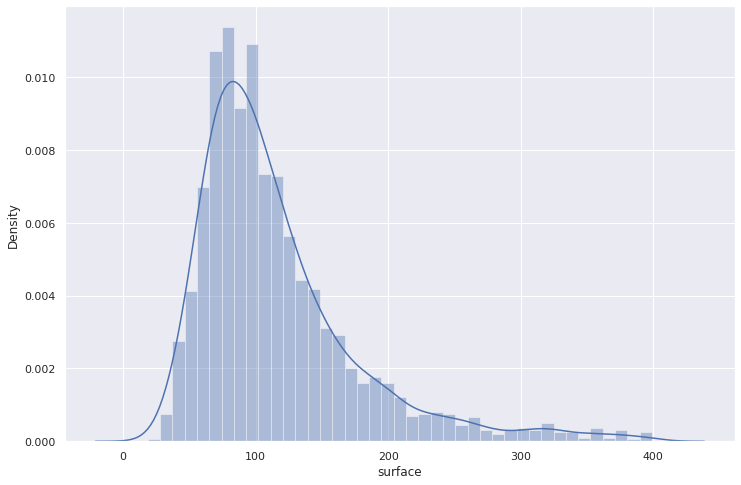


Columns : latitude


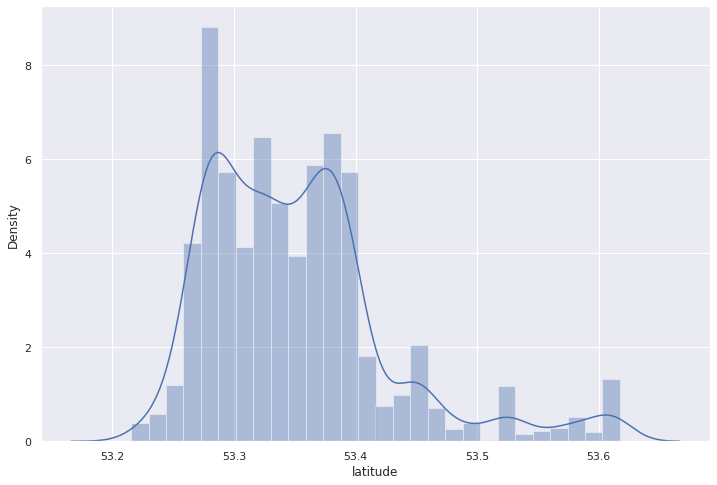


Columns : longitude


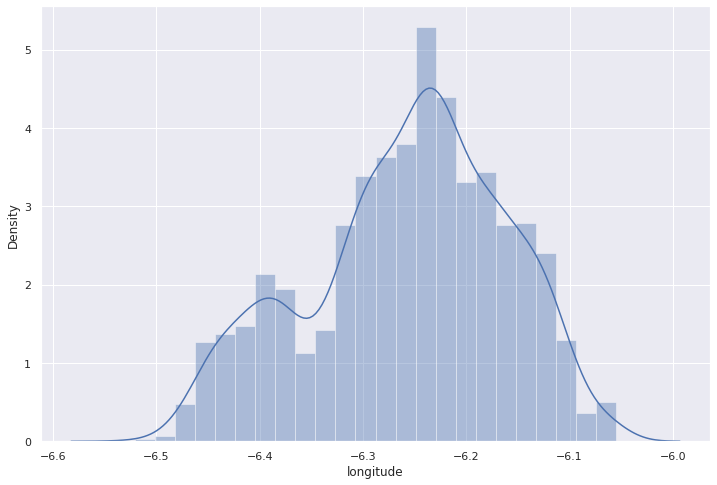


Columns : property_type


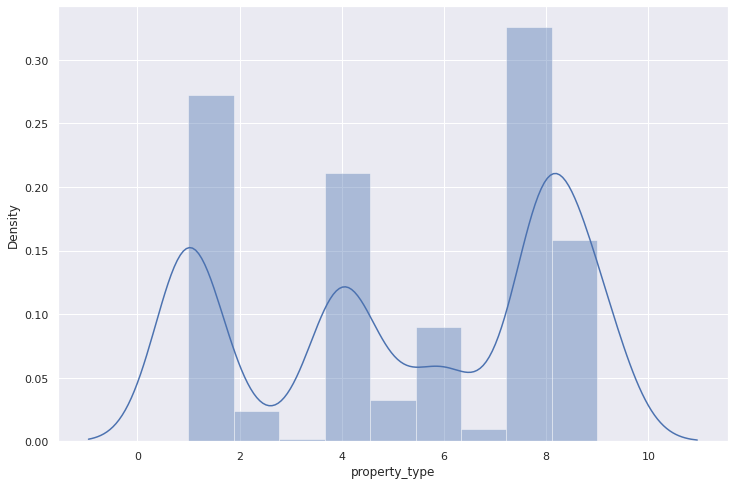

In [23]:
for column in [
    "postcode_north_south", "beds", "bathrooms", "surface", "latitude", "longitude", "property_type"]:
    print("Columns :", column)
    sns.distplot(house_train[column])
    plt.show()
    print("")

In [24]:
# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
X_train,X_test,y_train,y_test = \
    house_train.drop("Expected", axis = 1),\
    house_test.drop("Expected", axis = 1),\
    house_train["Expected"],\
    house_test["Expected"]

X_train["cost"] = y_train

len(X_train), len(X_test), len(y_train), len(y_test)

(2141, 453, 2141, 453)

# NATURAL LANGUAGE PROCESSING

Natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) is a subfield of linguistics, computer science, and artificial intelligence.

* NLP concerned with the interactions between computers and human language.
* In particular how to program computers to process and analyze large amounts of natural language data. 
* The goal is a computer capable of "understanding" the contents of documents.
* Including the contextual nuances of the language within them. 
* The technology can then accurately extract information and insights contained in the documents.
* As well as categorize and organize the documents themselves. 

We will look at description block and features and apply NLP to.  
The NLP we applied are:  
    * Remove the stopwords, because we are not interested in, like "the", "and", "is" which do not add to the prediction of house prices.
    * Apply TF-IDF  
        “Term Frequency — Inverse Document Frequency”. This is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [25]:
desc_column = "description_block"
feat_column = "features"

In [26]:
nltk.download('stopwords')

swords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/daire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()

y_train = y_train.reset_index()["Expected"]
y_test = y_test.reset_index()["Expected"]

In [28]:
for column in [desc_column, feat_column]:
    # tokenization
    tokenized_doc = X_train[column].fillna("").apply(lambda x: x.split())
    
    # remove stop-words
    tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in swords])

    # de-tokenization
    detokenized_doc = []
    for i in range(len(X_train)):
        t = ' '.join(tokenized_doc[i])
        detokenized_doc.append(t)
    X_train[column+"_clean"] = detokenized_doc

    # tokenization
    tokenized_doc = X_test[column].fillna("").apply(lambda x: x.split())
    
    # remove stop-words
    tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in swords])

    # de-tokenization
    detokenized_doc = []
    for i in range(len(X_test)):
        t = ' '.join(tokenized_doc[i])
        detokenized_doc.append(t)
    X_test[column+"_clean"] = detokenized_doc

In [29]:
vectoriser_desc = TfidfVectorizer(stop_words='english', max_features= 300, max_df=0.5, smooth_idf=True)

vectoriser_desc = vectoriser_desc.fit(X_train[desc_column+"_clean"])
tfidf_train_desc = vectoriser_desc.transform(X_train[desc_column+"_clean"])
tfidf_test_desc = vectoriser_desc.transform(X_test[desc_column+"_clean"])

tfidf_train_desc.shape, tfidf_test_desc.shape

((2141, 300), (453, 300))

In [30]:
vectoriser_desc = TfidfVectorizer(stop_words='english', max_features= 300, max_df=0.5, smooth_idf=True)

vectoriser_desc = vectoriser_desc.fit(X_train[feat_column+"_clean"])
tfidf_train_feat = vectoriser_desc.transform(X_train[feat_column+"_clean"])
tfidf_test_feat = vectoriser_desc.transform(X_test[feat_column+"_clean"])

tfidf_train_feat.shape, tfidf_test_feat.shape

((2141, 300), (453, 300))

### Combine TF-IDF data to training and test data

In [31]:
train_data = np.c_[X_train[feature_cols].values, tfidf_train_desc.toarray(), tfidf_train_feat.toarray()]
test_data = np.c_[X_test[feature_cols].values, tfidf_test_desc.toarray(), tfidf_test_feat.toarray()]

In [32]:
train_data.shape, test_data.shape

((2141, 638), (453, 638))

# PIECEWISE REGRESSION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

Regarding the peicewise regression, the below features are the most accurate.  
I would also like to add the features created in the NLP version, however the extra 300 columns add a lot of noise.  
Hence I am not adding the NLP columns.

In [33]:
regression_columns = ['longitude', 'latitude', 'surface', 'ber_classification', 'bathrooms',
       'beds', 'property_type', 'parking',
       'gas_fired_central_heating', 'postcode_north_south',
       'wired_for_cable_television', 'alarm']

regression_columns = feature_cols

### Base model

In [68]:
# train set, input columns
Xs_train = X_train[regression_columns].values 
# train set, output column, cost
ys_train = y_train.values.reshape(-1,1)   

# test set, input columns
Xs_test = X_test[regression_columns].values 
# test set, output column, cost

In [69]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

#ylog = np.log(ys_train.astype('float'))
ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [36]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    #like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 1,327.3


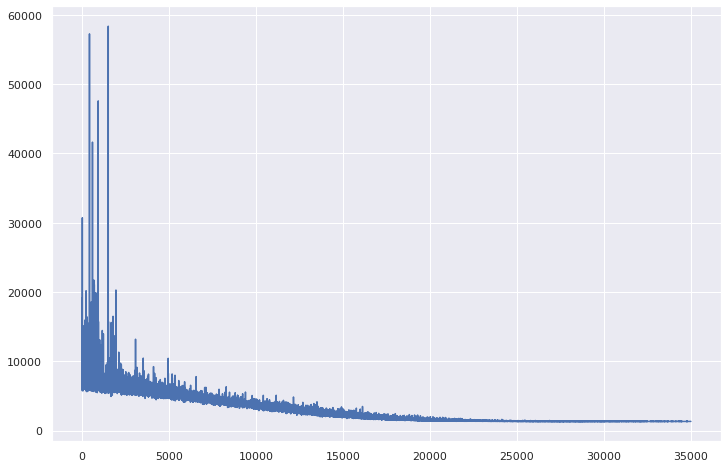

In [37]:
#number of iterations of the algorithms
iter = 35000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [38]:
# samples from the posterior
posterior = approximation.sample(5000)

In [39]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  103843.42349323163
MAPE =  0.16213965694275947


### Peicewise Model

In [40]:
# Our data is very high dimensional, compared to its size, so Piecewise Regressio would work better on lower dimesnions

In [41]:
# Number of components
component = 4

#### Cluster data

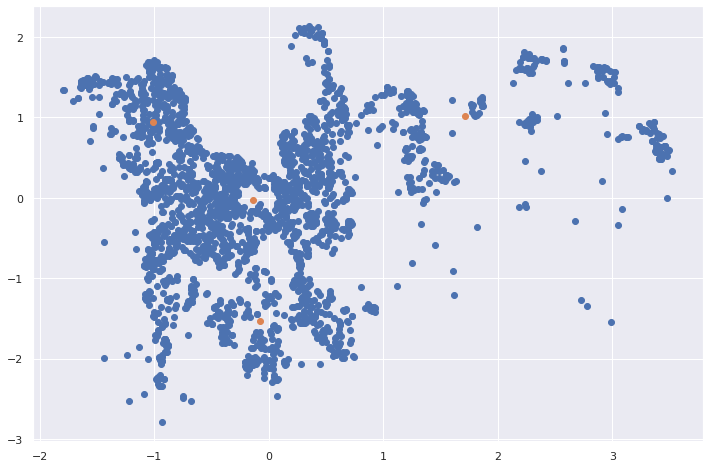

In [42]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

# Longitude and latitude
ind=[0,1]
component = 4

gmm = GaussianMixture(n_components=component)
# clustering by features 1, 2
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [43]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))


{0: 364, 1: 407, 2: 1044, 3: 326}

In [44]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 78, 1: 64, 2: 238, 3: 73}

#### Piecewise Model

In [45]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred


In [46]:
# Create a dictiornary to store cluster components
# This will allow the code to run more dynamically, and I could add extra clusters trivially

# Cluster Data
cd = {}

Cluster 0 has size of 364 rows.


Finished [100%]: Average Loss = 488.33


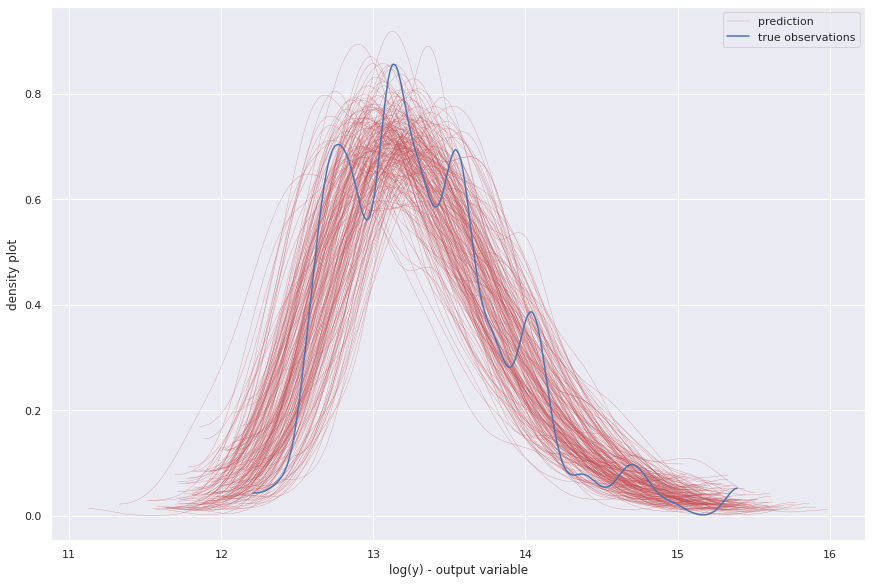

Cluster 1 has size of 407 rows.


Finished [100%]: Average Loss = 467.71


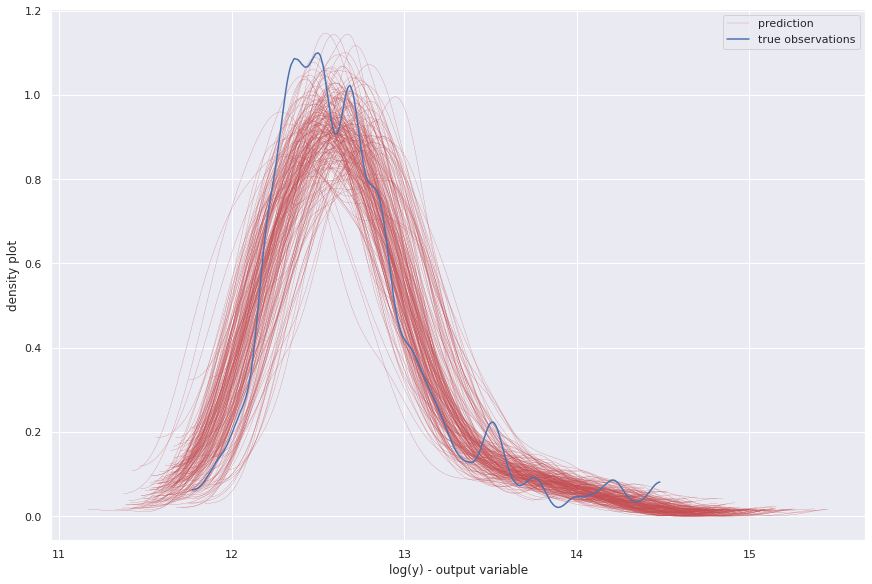

Cluster 2 has size of 1044 rows.


Finished [100%]: Average Loss = 734.97


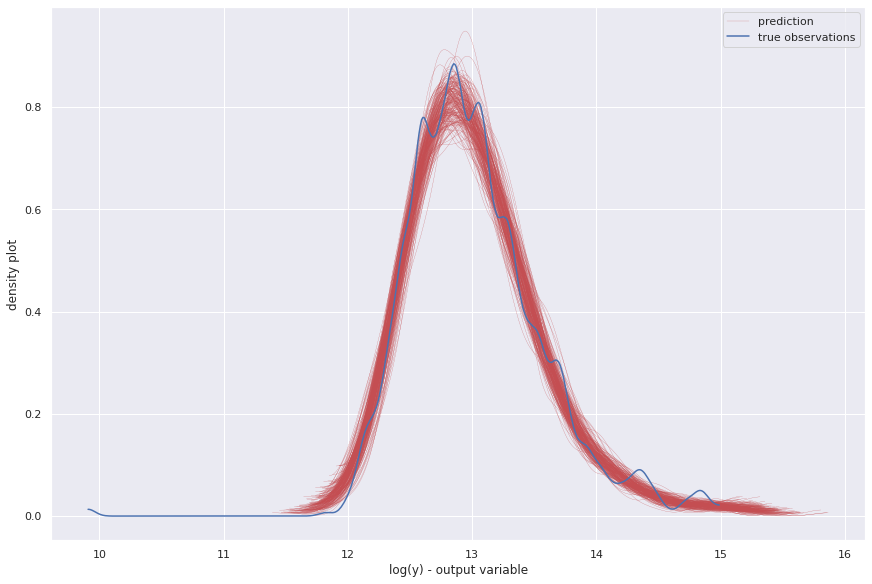

Cluster 3 has size of 326 rows.


Finished [100%]: Average Loss = 468.6


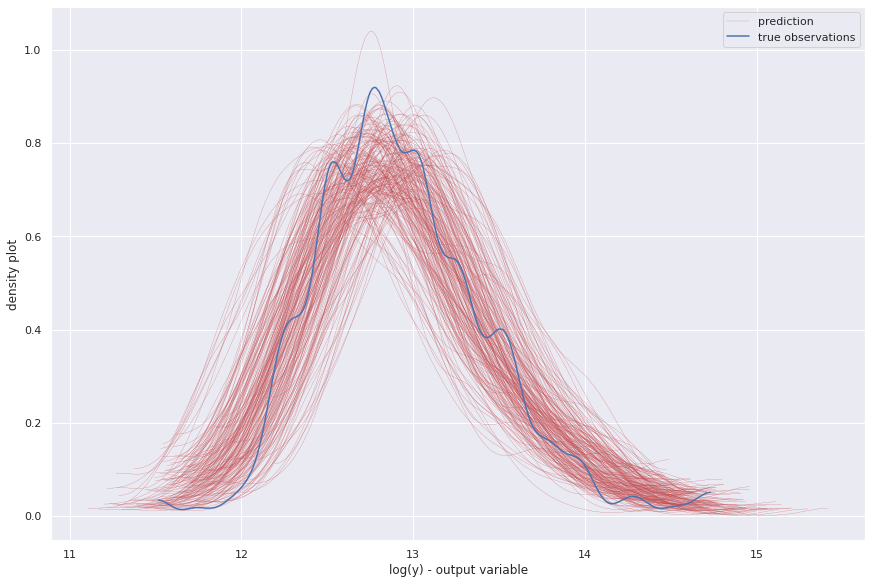

In [47]:
for j in range(component):
    cd_temp = {}
    cd_temp["Xn"] = Xn_train[clusters_train==j,:]
    cd_temp["Xtestn"] = Xn_test[clusters_test==j,:]

    cd_temp["ylog"] = np.log(ys_train.astype('float')[clusters_train==j,:])
    cd_temp["yscaler"] = StandardScaler().fit(cd_temp["ylog"])
    cd_temp["yn"] = cd_temp["yscaler"].transform(cd_temp["ylog"])
    print(f"Cluster {j} has size of {len(cd_temp['Xn'])} rows.")

    with pm.Model() as model_:
        # prior over the parameters of linear regression
        alpha = pm.Normal('alpha', mu=0, sigma=30)
        # we have a beta for each column of Xn0
        beta = pm.Normal('beta', mu=0, sigma=30, shape=cd_temp["Xn"].shape[1])
        # prior over the variance of the noise
        sigma = pm.HalfCauchy('sigma_n', 5)
        # linear regression relationship
        #linear regression model in matrix form
        mu = alpha + pm.math.dot(beta, cd_temp["Xn"].T)
        # likelihood, be sure that observed is a 1d vector
        like = pm.Normal('like', mu=mu, sigma=sigma, observed=cd_temp["yn"][:,0])

    with model_:
        # iterations of the algorithm
        approximation = pm.fit(40000,method='advi')

    # samples from the posterior   
    cd_temp["posterior"] = approximation.sample(5000)

    #Simulation
    Ypred = cd_temp["yscaler"].inverse_transform(ppc(
        cd_temp["posterior"]['alpha'],
        cd_temp["posterior"] ['beta'],
        cd_temp["posterior"] ['sigma_n'],cd_temp["Xn"],  nsamples=200))

    for i in range(Ypred.shape[0]):
        az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
    az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
    #plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
    #plt.xlim([0,10e7])
    az.plot_dist(cd_temp["ylog"],label='true observations');
    plt.legend()
    plt.xlabel("log(y) - output variable")
    plt.ylabel("density plot");
    plt.show()

    cd[j] = cd_temp


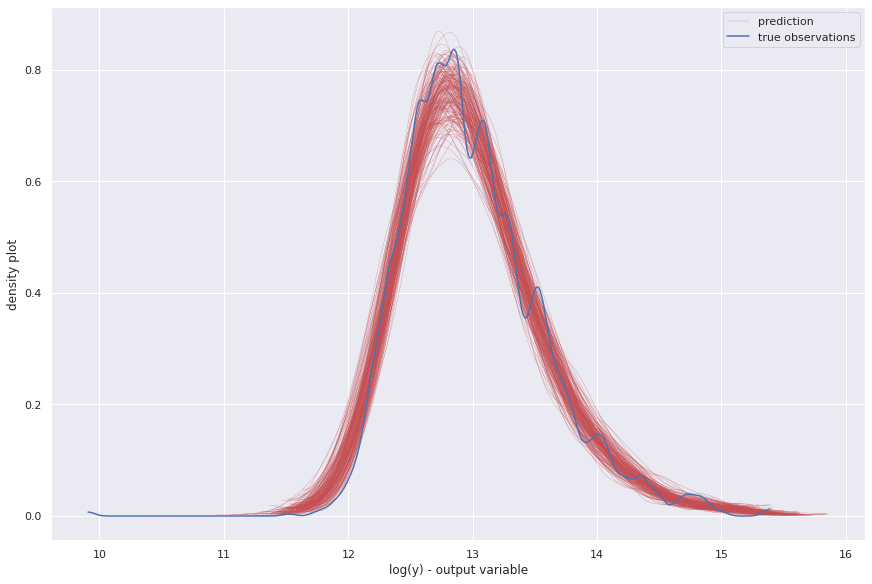

In [48]:
# posteriors
YPred_ = [cd[j]["yscaler"].inverse_transform(
    ppc(
        cd[j]["posterior"]['alpha'],
        cd[j]["posterior"]['beta'],
        cd[j]["posterior"]['sigma_n'],
        cd[j]["Xn"],
        nsamples=200)) for j in range(component)]

# simulation
Ypred = np.hstack(YPred_)

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([cd[j]["ylog"] for j in range(component)])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Test set performance

In [49]:
for j in range(component):
    y_pred_BLR = np.exp(cd[j]["yscaler"].inverse_transform(np.mean(cd[j]["posterior"]['alpha']) 
                  + np.dot(np.mean(cd[j]["posterior"]['beta'],axis=0), cd[j]["Xtestn"].T)))
    
    print(f"Size Cluster{j}", np.sum(clusters_test==j), f", MAE Cluster{j}=",
          (np.mean(abs(y_pred_BLR - y_test[clusters_test==j]))))
    
    cd[j]["y_pred_BLR"] = y_pred_BLR

abs_ = [
    abs(cd[j]["y_pred_BLR"] - y_test[clusters_test==j])
    for j in range(component)]

# joint
joint=np.hstack(abs_)

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 78 , MAE Cluster0= 150334.09382110808
Size Cluster1 64 , MAE Cluster1= 62865.07581201555
Size Cluster2 238 , MAE Cluster2= 92509.63548060475
Size Cluster3 73 , MAE Cluster3= 90809.08519618503
MAE= 98003.9307587657


The peicewise regression has an impressive score of 98000.  
This is better than I expected, and far better than the score for e-tivity 2.

# BAYESIAN NN

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

Your comments, explanation, and references here.

In [50]:
# A Neural Network would be better than a regression for high dimensional data.

We are going to create a Baysian Neural Network.  
We will use the NLP features.  
But first we will standardise the data. 

In [52]:
# train set, input columns
Xs_train = train_data
# train set, output column, cost

# test set, input columns
Xs_test = test_data
# test set, output column, cost

# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train_ = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test_ = xscaler.transform(Xss_test)

ys_train = y_train.values.reshape(-1,1)   

#ylog = np.log(ys_train.astype('float'))
ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

There are many features in the data.  
Therefore I apply PCA to clean the data, and only keep the top, most important principle components.

In [67]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
Xn_test = pca.fit_transform(Xn_test_)
Xn_train = pca.transform(Xn_train_)

print(sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

0.6176826560361827
[0.02232787 0.02023522 0.01672143 0.01397016 0.01204464 0.01170076
 0.01112303 0.01066475 0.01012027 0.01000147 0.00972642 0.00936485
 0.00911528 0.00867494 0.00855274 0.00853766 0.00828227 0.00798727
 0.00791502 0.00766306 0.00761448 0.00753809 0.00724807 0.00713583
 0.00708214 0.00697764 0.00688958 0.00676169 0.00660472 0.00649327
 0.00643214 0.00638818 0.00626052 0.00622705 0.00617971 0.00612162
 0.00604878 0.00604647 0.00592304 0.00581542 0.00579486 0.00571052
 0.00564051 0.00558249 0.00553975 0.00548966 0.00543696 0.00540356
 0.00531379 0.00520986 0.00515384 0.00512068 0.00504469 0.00496076
 0.00494473 0.00490441 0.00485036 0.00478413 0.0047312  0.00471503
 0.00466302 0.00462526 0.00457931 0.00454595 0.00447992 0.00446938
 0.00445131 0.00440134 0.00432706 0.00428496 0.00425233 0.00424717
 0.00422166 0.0041668  0.00410692 0.00406488 0.00402571 0.00401247
 0.00397874 0.00393089 0.00387195 0.00386224 0.00383614 0.00378101
 0.00376531 0.00373804 0.00370447 0.0036513

The above PCA components show the principle components are equally distributed with similiar importances.

In [54]:
# https://theano-pymc.readthedocs.io/en/latest/
import theano

# add a column of ones to include an intercept in the model
x1 = np.hstack([np.ones((Xn_train.shape[0],1)), Xn_train])
floatX = theano.config.floatX

l = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

# pymc3 model as neural_network
with pm.Model() as neural_network:
    # we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', yn_train)
    # Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=1,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_0', 0, sigma=1,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    # Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer, like in Linear regression
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    # standard deviation of noise
    sigma = pm.HalfCauchy('sigma',5)

    # Normal likelihood
    out = pm.Normal('out',
                   act_out,
                   sigma=sigma,
                   observed=ann_output[:,0])


In [ ]:
# some parameters
par1 = 100  # start with 100, then use 1000+
par2 = 1000 # start with 1000, then use 10000+

# neural network
with neural_network:
    posterior = pm.sample(par1,tune=par2,chains=1)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, w_0, w_1]


Specifically, PyMC3 supports the following Variational Inference (VI) methods:

  * Automatic Differentiation Variational Inference (ADVI): 'advi'
  * ADVI full rank: 'fullrank_advi'
  * Stein Variational Gradient Descent (SVGD): 'svgd'
  * Amortized Stein Variational Gradient Descent (ASVGD): 'asvgd'
  * Normalizing Flow with default scale-loc flow (NFVI): 'nfvi'


In [ ]:
# we can do instead an approximated inference
param3 = 30000 # start with 1000, then use 50000+
VI = 'advi'  # 'advi', 'fullrank_advi', 'svgd', 'asvgd', 'nfvi'
OP = pm.adam # pm.adam, pm.sgd, pm.adagrad, pm.adagrad_window, pm.adadelta
LR = 0.0008    

with neural_network:
    approx = pm.fit(param3, method=VI, obj_optimizer=pm.adam(learning_rate=LR))


In [ ]:
# plot 
pb.plot(approx.hist, label='Variational Inference: '+ VI.upper(), alpha=.3)
pb.legend(loc='upper right')
# Evidence Lower Bound (ELBO)
# https://en.wikipedia.org/wiki/Evidence_lower_bound
pb.ylabel('ELBO')
pb.xlabel('iteration');

In [ ]:
# draw samples from variational posterior
D = 300
posterior = approx.sample(draws=D)

Now, we compute the prediction for each sample. 
* Note that we use `np.tanh` instead of `pm.math.tanh`
for speed reason. 
* `pm.math.tanh` is slower outside a Pymc3 model because it converts all data in theano format.
* It is convenient to do GPU-based training, but it is slow when we only need to compute predictions.

In [ ]:
# add a column of ones to include an intercept in the model
x2 = np.hstack([np.ones((Xn_test.shape[0],1)), Xn_test])
y_final_pred = []
for i in range(posterior['w_1'].shape[0]):
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x2.T))
    #outer layer
    y_final_pred.append(np.dot(posterior['w_0'][i,:],t1))

# predictions   
y_final_pred = np.array(y_final_pred).mean(axis=0)

In [ ]:
#We need to do the inverse transformation and scaling that was carried out on the y values at the start
y_val_pred_final = np.exp(yscaler.inverse_transform(y_final_pred))

In [ ]:
print("MAE = ",(np.mean(abs(y_val_pred_final - y_test))))
print("MAPE = ",(np.mean(abs(y_val_pred_final - y_test) / y_test)))

Unfortunatly, the MAE of the Baysian Neural Network is 130000, which is higher than the peicewise regression of 90000.

# SUMMARY

We have used peicewise regression and baysian NN to predict teh house prices.

Peicewise Regression MAE: 90000  
Baysian Neural Network MAE: 130000

# References